In [17]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.manifold import MDS
from tensorflow.keras import models
from keras.utils import to_categorical
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Model, Sequential
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import SpectralEmbedding

In [3]:
def load_fashion_mnist_from_csv(train_csv_path, test_csv_path):
    # Load training data
    train_df = pd.read_csv(train_csv_path)
    train_labels = train_df['label'].values
    train_pixels = train_df.drop('label', axis=1).values.reshape(-1,784)

    # Load test data
    test_df = pd.read_csv(test_csv_path)
    test_labels = test_df['label'].values
    test_pixels = test_df.drop('label', axis=1).values.reshape(-1,784)

    return (train_pixels, train_labels), (test_pixels, test_labels)

(train, train_label), (test, test_label) = load_fashion_mnist_from_csv('fashion-mnist_train.csv', 'fashion-mnist_test.csv')

In [4]:
num_samples = 1000
idx = np.random.choice(train.shape[0], num_samples, replace=False)
subset_train = train[idx]
subset_train_labels = train_label[idx]

In [5]:
subset_train_reshaped = subset_train.reshape(-1, 784)

In [10]:
# Apply MDS
embedding = MDS(metric=True,n_components=2,eps=0.001)
train_transformed = embedding.fit_transform(subset_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [11]:
# Apply Isomap
isomap = Isomap(n_components=2,n_neighbors=30)
transformed_isomap_data = isomap.fit_transform(subset_train)

In [14]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=7, random_state=42)
transformed_tsne_data = tsne.fit_transform(subset_train)

In [16]:
# Apply LLE 
lle = LocallyLinearEmbedding(n_neighbors=10, n_components=2)
transformed_lle_data = lle.fit_transform(subset_train)

In [18]:
# Apply Spectral
spectral = SpectralEmbedding(n_neighbors=10, n_components=2)
transformed_spectral_data = spectral.fit_transform(subset_train)

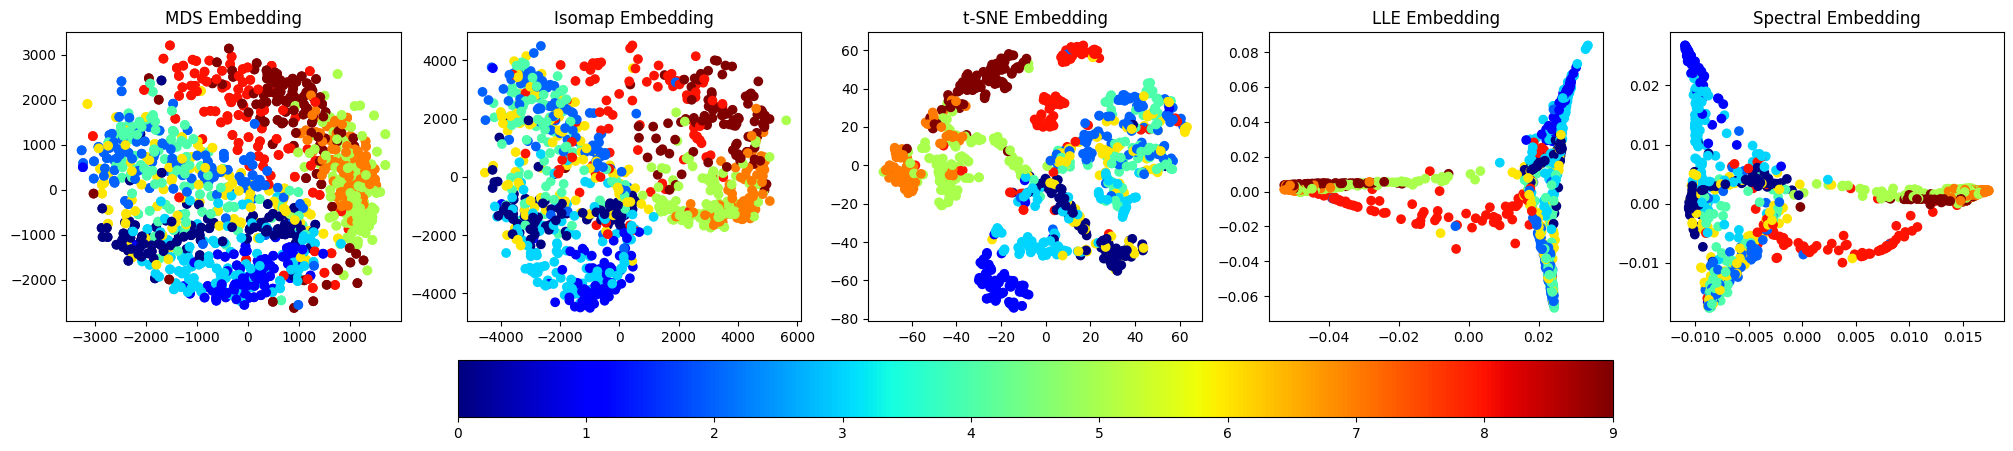

In [19]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

# MDS
axs[0].scatter(train_transformed[:, 0], train_transformed[:, 1], c=subset_train_labels, cmap='jet')
axs[0].set_title('MDS Embedding')

# Isomap
axs[1].scatter(transformed_isomap_data[:, 0], transformed_isomap_data[:, 1], c=subset_train_labels, cmap='jet')
axs[1].set_title('Isomap Embedding')

# t-SNE
axs[2].scatter(transformed_tsne_data[:, 0], transformed_tsne_data[:, 1], c=subset_train_labels, cmap='jet')
axs[2].set_title('t-SNE Embedding')

# LLE
axs[3].scatter(transformed_lle_data[:, 0], transformed_lle_data[:, 1], c=subset_train_labels, cmap='jet')
axs[3].set_title('LLE Embedding')

# Spectral
axs[4].scatter(transformed_spectral_data[:, 0], transformed_spectral_data[:, 1], c=subset_train_labels, cmap='jet')
axs[4].set_title('Spectral Embedding')

plt.colorbar(axs[0].scatter(train_transformed[:, 0], train_transformed[:, 1], c=subset_train_labels, cmap='jet'), ax=axs, orientation='horizontal', pad=0.1)
plt.show()

In [20]:
classifiers = {
    'LDA': LinearDiscriminantAnalysis(),
    'KNN (K=1)': KNeighborsClassifier(n_neighbors=1),
    'KNN (K=3)': KNeighborsClassifier(n_neighbors=3),
    'KNN (K=5)': KNeighborsClassifier(n_neighbors=5),
    #'SVM Linear': SVC(kernel='linear'),
    #'SVM RBF': SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(),
    'Multinomial Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000) 
}

In [22]:
X_train, X_test, y_train, y_test = train_test_split(subset_train, subset_train_labels, test_size=0.3, random_state=42)

In [23]:
print(X_train.shape)
print(X_test.shape)

(700, 784)
(300, 784)


In [24]:
no_embedding_accuracies = {}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    no_embedding_accuracies[name] = accuracy

In [25]:
no_embedding_mean_std = {
    name: f"{np.mean(accs):.2f} ± {np.std(accs):.2f}"
    for name, accs in no_embedding_accuracies.items()}

no_embedding_df = pd.DataFrame([no_embedding_mean_std], index=['No Embedding'])
no_embedding_df

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),Random Forest,Multinomial Logistic Regression
No Embedding,0.43 ± 0.00,0.74 ± 0.00,0.72 ± 0.00,0.73 ± 0.00,0.82 ± 0.00,0.76 ± 0.00


In [30]:
metrics = [True]
eps_values = [0.001, 0.01, 0.1]
embeddings = {}
for metric_value in metrics:
    for eps in eps_values:
        embedding = MDS(n_components=10, metric=metric_value, eps=eps)
        train_transformed = embedding.fit_transform(subset_train)
        embeddings[(metric_value, eps)] = train_transformed

mds_accuracy_results = {name: [] for name in classifiers.keys()}

for (metric_value, eps), train_transformed in embeddings.items():
    X_train, X_test, y_train, y_test = train_test_split(train_transformed, subset_train_labels, test_size=0.3, random_state=42)
    
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        mds_accuracy_results[name].append(accuracy)

mds_mean_std_accuracy_results = {}
for name, acc_list in mds_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    mds_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

mds_df = pd.DataFrame([mds_mean_std_accuracy_results], index=['MDS'])
mds_df

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.p

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),Random Forest,Multinomial Logistic Regression
MDS,0.71 ± 0.01,0.68 ± 0.01,0.69 ± 0.01,0.71 ± 0.01,0.74 ± 0.00,0.74 ± 0.01
